He HUANG/LI M2/22107447

# M2 project : NER tagging

This project aims to implement a NER Tagger with Pytorch. We will be using the English CONLL 2003 data set.

Data download & description
--------

In [ ]:
from urllib.request import urlretrieve
urlretrieve('https://raw.githubusercontent.com/pranabsarkar/Conll_task/master/conll-2003/eng.train','eng.train')
urlretrieve('https://raw.githubusercontent.com/pranabsarkar/Conll_task/master/conll-2003/eng.testa','eng.testa')

#Prints the beginning of the training set
istream = open('eng.testa')
for idx, line in enumerate(istream):
  print(line.strip())
  if idx >=20:
    break
istream.close()

-DOCSTART- -X- -X- O

CRICKET NNP I-NP O
- : O O
LEICESTERSHIRE NNP I-NP I-ORG
TAKE NNP I-NP O
OVER IN I-PP O
AT NNP I-NP O
TOP NNP I-NP O
AFTER NNP I-NP O
INNINGS NNP I-NP O
VICTORY NN I-NP O
. . O O

LONDON NNP I-NP I-LOC
1996-08-30 CD I-NP O

West NNP I-NP I-MISC
Indian NNP I-NP I-MISC
all-rounder NN I-NP O
Phil NNP I-NP I-PER


The CONLL 2003 dataset encodes each token on a single line followed by its annotation. A token line is a quadruple:

> (token,tag,chunk,named entity)

A named entity tagger aims to predict the named entity annotations given the raw tokens. The NER tags follows the IOB convention.
* **I** stands for **Inside** and is used to flag tokens that are part of a named entity.
* **B** stands for **Begin** and is used to flag a token starting a new entity when the preceding token is already part of an entity.
* **O** stands for **Outside** and is used to flag tokens that are not part of a named entity.

The I and B Tag are followed by a specifier. For instance I-PER means that the named entity refers to a person, I-ORG means that the entity is refers to an Organisation.

Sentences are separated by a blank line. The train file is `eng.train`, the dev file is `eng.testa`. I will evaluate your work with a test file unknown to you.
To do this, I will change the content of the dev file



First exercise : data preprocessing (5pts)
---


Using CONLL2003 the train file, you will:

* Extract an input vocabulary and create two maps: one mapping tokens to integers and a second mapping integers to tokens (see the pdf notes)
* Include elements in the input vocabulary for padding and for unknown words
* Extract an output vocabulary (the set of NER tags) and returns two maps
mapping tags to integer and vice-versa.

These functionalities should be implemented in a function with signature `vocabulary(filename)` that returns the two maps

In [ ]:
def vocabulary(filename,input_vocab,padding='<pad>',unknown='<unk>'):
    #input_vocab is a boolean flag that tells if we extract input or output vocabulary
    #the two optional flags indicate that a padding and an unknown token
    #have to be added to the vocabulary if their value is not None

    istream = open(filename)
    lines = istream.readlines()

    vocab = []
    ner = []
    # Output vocabulary dictionary
    idx2sym = {}
    sym2idx = {}

    if input_vocab:
      for line in lines:
        line = line.split(' ')
        if line[0] != '\n' and line[0] != '-DOCSTART-' and line[0] not in vocab:
          word = line[0]
          vocab.append(word)
      # Padding and add unknown word
      vocab.append(padding)
      vocab.append(unknown)
      # Maps symbols to integers
      sym2idx = {sym: idx for (idx,sym) in enumerate(vocab)}
      idx2sym = {v: k for k,v in sym2idx.items()}

    # If not using input_vocab
    else:
      for line in lines:
        line = line.strip()
        if line !='':
           line = line.split(' ')
           if line[0] != '\n' and line[0] != '-DOCSTART-' and line[-1] not in ner:
            tag = line[-1]
            ner.append(tag) # add the tag
      ner.append(padding) # also, we need to add the padding token
      # Maps symbols to integers
      sym2idx = {sym: idx for (idx,sym) in enumerate(ner)}
      idx2sym = {v: k for k,v in sym2idx.items()}

    return idx2sym,sym2idx
    istream.close()


    #TODO : return the two vocabulary maps idx2sym and sym2idx

In [ ]:
# Test block
w = vocabulary('eng.train', True)
print(len(w[0]))

23625


In [ ]:
t = vocabulary('eng.train', False)
print(t[0])

{0: 'I-ORG', 1: 'O', 2: 'I-MISC', 3: 'I-PER', 4: 'I-LOC', 5: 'B-LOC', 6: 'B-MISC', 7: 'B-ORG', 8: '<pad>'}


Now we implement three functions:

* One that performs padding
* The second will encode a sequence of tokens (or a sequence of tags) on integers
* The third will decode as sequence of symbols from integers to strings

At test time, some tokens might not belong to the vocabulary. Ensure that your encoding function does not crash in this case.


In [ ]:
def pad_sequence(sequence,pad_size,pad_token):
    #returns a list with additional pad tokens if needed

    return sequence + [pad_token]*(pad_size-len(sequence))

def code_sequence(sequence,coding_map,unk_token=None):
    #takes a list of strings and returns a list of integers
    if not unk_token:
        return [coding_map[word] for word in sequence]

    # unk token need to be added
    else:
        new_sequence = []
        for word in sequence:
            if word in coding_map:
                new_sequence.append(coding_map[word])
            else:
                new_sequence.append(coding_map[unk_token])
        return new_sequence

def decode_sequence(sequence,decoding_map):
    #takes a list of integers and returns a list of strings
    return [decoding_map[idx] for idx in sequence]

Second exercise: data generator (5pts)
------

In this second exercise, we will write a mini-batch generator.
This is a class in charge of generating randomized batches of data from the dataset. We start by implementing two functions for reading the textfile


In [ ]:
def read_conll_tokens(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (tokens)
    """
    #TODO
    istream = open(conllfilename)

    tokens = []
    sents = []

    line = istream.readline().strip()
    line = istream.readline().strip()
    line = istream.readline().strip()

    while line != '':
        line = line.split(' ')
        if line[0] != "-DOCSTART-":
            tokens.append(line[0])
        line = istream.readline().strip()
        if line == '':
            if tokens:
                sents.append(tokens)
            tokens = []
            line = istream.readline().strip()
    istream.close()
    return sents


def read_conll_tags(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (NER-tags)
    """
    #TODO
    istream = open(conllfilename)

    tagger = []
    ners = []

    line = istream.readline().strip()
    line = istream.readline().strip()
    line = istream.readline().strip()

    while line != '':
        line = line.split(' ')
        if line[0] != "-DOCSTART-":
            tagger.append(line[3])
        line = istream.readline().strip()
        if line == '':
            if tagger:
                ners.append(tagger)
            tagger = []
            line = istream.readline().strip()
    istream.close()
    return ners

In [ ]:
tokens = read_conll_tokens('eng.train')
len(tokens)

14041

In [ ]:
tags = read_conll_tags('eng.train')
len(tags)

14041

In [ ]:
len(tokens) == len(tags)

True



Now we implement the class. You will rely on the helper functions designed above in order to fill in the blanks in the constructor.

In [ ]:
import torch
import torch.nn as nn
from random import shuffle

class DataGenerator:

        #Reuse all relevant helper functions defined above to solve the problems
        def __init__(self,conllfilename, parentgenerator = None, pad_token='<pad>',unk_token='<unk>'):

              if parentgenerator is not None: #Reuse the encodings of the parent if specified
                  self.pad_token      = parentgenerator.pad_token
                  self.unk_token      = parentgenerator.unk_token
                  self.input_sym2idx  = parentgenerator.input_sym2idx
                  self.input_idx2sym  = parentgenerator.input_idx2sym
                  self.output_sym2idx = parentgenerator.output_sym2idx
                  self.output_idx2sym = parentgenerator.output_idx2sym
              else:                           #Creates new encodings
                  self.pad_token = pad_token
                  self.unk_token = unk_token
                  #TODO : Create 4 encoding maps from datafile
                  word = vocabulary(conllfilename,True,self.pad_token,self.unk_token)
                  tag = vocabulary(conllfilename,False,self.pad_token,self.unk_token)

                  self.input_idx2sym,self.input_sym2idx   = word[0],word[1]
                  self.output_idx2sym,self.output_sym2idx = tag[0],tag[1]


              #TODO : store the conll dataset with sentence structure (a list of lists of strings) in the following fields
              self.Xtokens = read_conll_tokens(conllfilename)
              self.Ytokens = read_conll_tags(conllfilename)


        def generate_batches(self,batch_size):

              #This is an example generator function yielding one batch after another
              #Batches are lists of lists

              assert(len(self.Xtokens) == len(self.Ytokens))

              N     = len(self.Xtokens)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.Xtokens[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.Xtokens[idx]) for idx in batch_idxes)

                 seqX = [ pad_sequence(self.Xtokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqY = [ pad_sequence(self.Ytokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqX = [ code_sequence(seq,self.input_sym2idx,self.unk_token) for seq in seqX]
                 seqY = [ code_sequence(seq,self.output_sym2idx) for seq in seqY]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size

In [ ]:
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)

for (seqX,seqY) in trainset.generate_batches(32):
    print(seqX)
    print(seqY)
    print("------")

[[3417], [21102], [5937], [17734], [16151], [1686], [159], [1303], [22654], [1285], [6901], [21580], [2325], [22697], [11356], [6901], [2928], [132], [1323], [21071], [2077], [2263], [4768], [11371], [2076], [3769], [3769], [8], [1656], [7359], [20405], [17664]]
[[1], [1], [1], [0], [4], [1], [1], [0], [1], [4], [1], [1], [1], [1], [0], [1], [1], [1], [4], [0], [1], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1]]
------
[[1285], [8374], [2077], [7170], [218], [57], [159], [1303], [12], [1686], [17664], [10551], [1313], [2928], [14782], [1432], [23268], [2076], [18913], [3559], [9013], [11950], [2083], [15200], [10883], [57], [1323], [10422], [2076], [12248], [13335], [17664]]
[[4], [1], [1], [3], [0], [1], [1], [0], [1], [1], [1], [0], [0], [1], [0], [4], [1], [1], [1], [3], [1], [2], [1], [1], [1], [1], [4], [1], [1], [1], [0], [1]]
------
[[389], [3769], [3928], [12917], [18128], [2928], [22534], [23272], [12], [2928], [23267], [22245], [16216], [8180], [159], [15200], [21090]

Third exercise : implement the tagger (5pts)
---------------
This is the core exercise. There are three main tasks:
* Implement parameter allocation. This implies allocating the embedding layer, the LSTM (or bi-LSTM) layer and the Linear Layer.
* Implement the forward method. This method expects a tensor encoding the input and outputs a tensor of predictions
* Implement the train method

The evaluation (`validate`) method is given and cannot be modified. But it can be used as source of inspiration for implementing the train method.

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

class NERtagger(nn.Module):

      def __init__(self,traingenerator, embedding_size,hidden_size,device='cuda'):
        super(NERtagger, self).__init__()
        self.embedding_size    = embedding_size
        self.hidden_size       = hidden_size
        self.allocate_params(traingenerator,device)
        self.device = device
        # store the accuracy and loss
        self.loss = []
        self.accuracy = []

      def load(self,filename):
        self.load_state_dict(torch.load(filename))

      def allocate_params(self,datagenerator,device):

        #create fields for nn Layers
        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)
        pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]

        self.embedding = nn.Embedding(invocab_size,self.embedding_size).to(device)
        self.lstm = nn.LSTM(self.embedding_size,self.hidden_size).to(device)
        self.linear_output = nn.Linear(self.hidden_size,outvocab_size)
        self.linear_output = self.linear_output.to(device)

      def forward(self,Xinput):

        #prediction steps
        Xinput = Xinput.to(self.device)
        embeds = self.embedding(Xinput).to(self.device)
        # batched prediction
        H,(hidden,cell) = self.lstm(embeds)
        H = H.to(self.device)
        output = self.linear_output(H).to(self.device)

        return output

      def train(self,traingenerator,validgenerator,epochs,batch_size,device='cuda',learning_rate=0.001):

        self.minloss = 10000000 #the min loss found so far on validation data

        batch_losses = []
        device = torch.device(device)
        optimizer = torch.optim.SGD(self.parameters(),lr=learning_rate, momentum=0.99)
        pad_index = traingenerator.output_sym2idx[traingenerator.pad_token]
        #loss function do not compute loss for padded symbols
        loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index).to(device)

        for i in range(epochs):
            loss = 0.0
            training_losses = []
            for (seqX,seqY) in traingenerator.generate_batches(batch_size):
                optimizer.zero_grad()
                # encoding must be stored in a LongTensor
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)
                Yhat = self.forward(X).to(device)
                # Flattening
                batch_size,seq_len = Y.shape
                Yhat = Yhat.view(batch_size*seq_len,-1)
                Y = Y.view(batch_size*seq_len)
                # Computing the loss
                loss = loss_fnc(Yhat,Y).to(device)
                loss.backward()
                training_losses.append(loss.item())
                optimizer.step()
            batch_losses.append(training_losses)
            self.validate(validgenerator,batch_size,device)


      def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False):

          batch_accurracies = []
          batch_losses      = []

          device = torch.device(device)
          pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
          loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index)

          for (seqX,seqY) in datagenerator.generate_batches(batch_size):
                with torch.no_grad():
                  X = torch.LongTensor(seqX).to(device)
                  Y = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)

                  #Flattening and loss computation
                  batch_size,seq_len = Y.shape
                  Yhat = Yhat.view(batch_size*seq_len,-1)
                  Y    = Y.view(batch_size*seq_len)
                  loss = loss_fnc(Yhat,Y)
                  batch_losses.append(loss.item())

                  #Accurracy computation
                  mask    = (Y != pad_index)
                  Yargmax = torch.argmax(Yhat,dim=1)
                  correct = torch.sum((Yargmax == Y) * mask)
                  total   = torch.sum(mask)
                  batch_accurracies.append(float(correct)/float(total))

          L = len(batch_losses)
          valid_loss = sum(batch_losses)/L
          self.loss.append(valid_loss)

          if save_min_model and valid_loss < self.minloss:
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'tagger_params.pt')
          self.accuracy.append(sum(batch_accurracies)/L)
          print('[valid] mean Loss = %f | mean accurracy = %f'%(valid_loss,sum(batch_accurracies)/L))

      def plot_curves(self):
          plt.figure(figsize=(10,5))
          plt.xlabel('epoch')
          plt.ylabel('accuracy and loss')
          plt.plot(self.accuracy,label='accuracy')
          plt.plot(self.loss,label='loss')
          plt.legend()
          plt.show()

The main program is the following. You are expected to add code for searching for hyperparameters that maximise the validation score

In [ ]:
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)
tagger   = NERtagger(trainset,64,128,device='cuda')
tagger.train(trainset,validset,20,32,device='cuda')

#ADD CODE for searching reasonable hyperparameters

[valid] mean Loss = 0.952125 | mean accurracy = 0.770860
[valid] mean Loss = 0.875456 | mean accurracy = 0.770865
[valid] mean Loss = 0.808106 | mean accurracy = 0.771113
[valid] mean Loss = 0.739754 | mean accurracy = 0.777294
[valid] mean Loss = 0.542544 | mean accurracy = 0.826608
[valid] mean Loss = 0.424300 | mean accurracy = 0.862930
[valid] mean Loss = 0.380293 | mean accurracy = 0.884797
[valid] mean Loss = 0.348877 | mean accurracy = 0.898393
[valid] mean Loss = 0.342577 | mean accurracy = 0.849114
[valid] mean Loss = 0.366048 | mean accurracy = 0.855915
[valid] mean Loss = 0.407745 | mean accurracy = 0.859997
[valid] mean Loss = 0.421992 | mean accurracy = 0.863494
[valid] mean Loss = 0.434563 | mean accurracy = 0.866090
[valid] mean Loss = 0.456707 | mean accurracy = 0.867410
[valid] mean Loss = 0.467710 | mean accurracy = 0.868280
[valid] mean Loss = 0.502442 | mean accurracy = 0.869013
[valid] mean Loss = 0.513227 | mean accurracy = 0.868754
[valid] mean Loss = 0.547969 | 

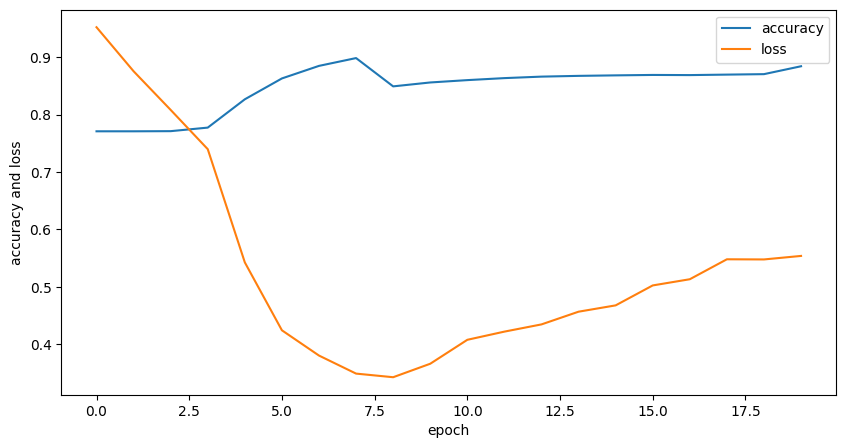

In [ ]:
tagger.plot_curves()

In [ ]:
# Search for the best hyperparameters
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)
epochs = [10,15,20]
batch_size = [32,64,128]
lrs = [0.001,0.005,0.01]
accuracy_list = []
hyperparameters = []

for epoch in epochs:
    for b in batch_size:
        for lr in lrs:
            hyperparameters.append([epoch,b,lr])
            print(f"epoch: {epoch}, batch_size:{b}, learning_rate:{lr}")

            tagger = NERtagger(trainset,64,128,device='cuda')
            tagger.train(trainset,validset,epoch,b,device='cuda',learning_rate=lr)
            min_loss = min(tagger.loss)
            max_accuracy = max(tagger.accuracy)
            accuracy_list.append(max_accuracy)
best_accuracy = max(accuracy_list)
idx_best = accuracy_list.index(best_accuracy)
best_hyperparameters = hyperparameters[idx_best]

print(f"Best accuracy: {best_accuracy}")
print(f"Best hyperparameters: epoch:{best_hyperparameters[0]}, batch_size:{best_hyperparameters[1]}, learning_rate:{best_hyperparameters[2]}")

epoch: 10, batch_size:32, learning_rate:0.001
[valid] mean Loss = 0.938431 | mean accurracy = 0.770772
[valid] mean Loss = 0.899261 | mean accurracy = 0.770885
[valid] mean Loss = 0.817343 | mean accurracy = 0.771769
[valid] mean Loss = 0.761378 | mean accurracy = 0.778139
[valid] mean Loss = 0.544573 | mean accurracy = 0.824638
[valid] mean Loss = 0.429536 | mean accurracy = 0.861575
[valid] mean Loss = 0.373642 | mean accurracy = 0.886386
[valid] mean Loss = 0.358357 | mean accurracy = 0.898344
[valid] mean Loss = 0.330101 | mean accurracy = 0.908443
[valid] mean Loss = 0.327365 | mean accurracy = 0.870661
epoch: 10, batch_size:32, learning_rate:0.005
[valid] mean Loss = 0.824860 | mean accurracy = 0.770856
[valid] mean Loss = 0.722128 | mean accurracy = 0.778942
[valid] mean Loss = 0.673346 | mean accurracy = 0.792818
[valid] mean Loss = 0.598163 | mean accurracy = 0.825882
[valid] mean Loss = 0.481071 | mean accurracy = 0.874110
[valid] mean Loss = 0.526721 | mean accurracy = 0.892

In [ ]:
# Run the best hyperparameters
tagger_v1   = NERtagger(trainset,64,128,device='cuda')
tagger_v1.train(trainset,validset,20,128,device='cuda',learning_rate=0.005)

[valid] mean Loss = 1.002236 | mean accurracy = 0.771751
[valid] mean Loss = 0.840957 | mean accurracy = 0.770944
[valid] mean Loss = 0.835701 | mean accurracy = 0.770836
[valid] mean Loss = 0.726490 | mean accurracy = 0.774536
[valid] mean Loss = 0.662849 | mean accurracy = 0.795845
[valid] mean Loss = 0.554492 | mean accurracy = 0.830998
[valid] mean Loss = 0.566181 | mean accurracy = 0.866237
[valid] mean Loss = 0.413367 | mean accurracy = 0.895175
[valid] mean Loss = 0.342226 | mean accurracy = 0.907259
[valid] mean Loss = 0.344336 | mean accurracy = 0.917184
[valid] mean Loss = 0.404100 | mean accurracy = 0.923392
[valid] mean Loss = 0.408811 | mean accurracy = 0.925114
[valid] mean Loss = 0.434406 | mean accurracy = 0.927767
[valid] mean Loss = 0.451500 | mean accurracy = 0.927993
[valid] mean Loss = 0.464032 | mean accurracy = 0.928856
[valid] mean Loss = 0.469701 | mean accurracy = 0.928352
[valid] mean Loss = 0.484813 | mean accurracy = 0.929862
[valid] mean Loss = 0.516036 | 

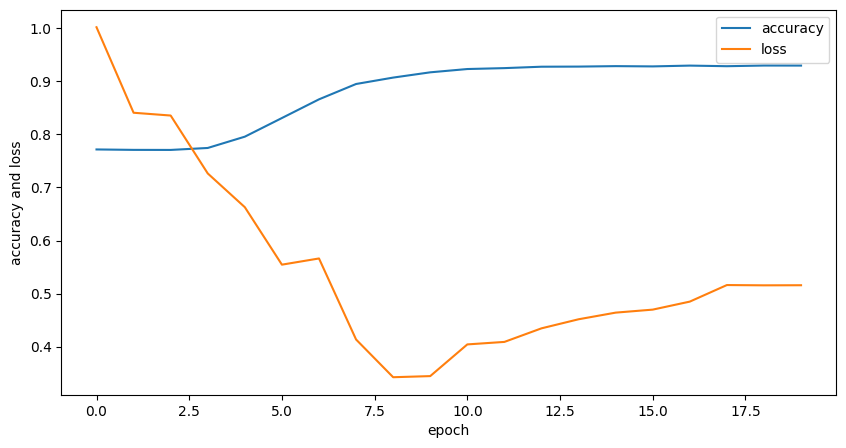

In [ ]:
tagger_v1.plot_curves()

Fourth exercise : improve the tagger (5pts)
----------

This exercise is relatively free. You may add improvements to the basic tagger.
Note that I expect that improving the management of unknown words and of subword units is key on this task. You may wish to:
* Add an attention layer
* Use part of speech tags embeddings as additional inputs
* Find a way to learn a word embedding for unknown words
* Integrate your convolutional word embedding module into the tagger
* ...

Describe your improvements below and point me out the name(s) of the function(s)
where they are implemented.


### Add an attention layer

In [ ]:
def vocabulary(filename,input_vocab,padding='<pad>',unknown='<unk>'):
    #input_vocab is a boolean flag that tells if we extract input or output vocabulary
    #the two optional flags indicate that a padding and an unknown token
    #have to be added to the vocabulary if their value is not None

    istream = open(filename)
    lines = istream.readlines()

    vocab = []
    ner = []
    # Output vocabulary dictionary
    idx2sym = {}
    sym2idx = {}

    if input_vocab:
      for line in lines:
        line = line.split(' ')
        if line[0] != '\n' and line[0] != '-DOCSTART-' and line[0] not in vocab:
          word = line[0]
          vocab.append(word)
      # Padding and add unknown word
      vocab.append(padding)
      vocab.append(unknown)
      # Maps symbols to integers
      sym2idx = {sym: idx for (idx,sym) in enumerate(vocab)}
      idx2sym = {v: k for k,v in sym2idx.items()}

    # If not using input_vocab
    else:
      for line in lines:
        line = line.strip()
        if line !='':
           line = line.split(' ')
           if line[0] != '\n' and line[0] != '-DOCSTART-' and line[-1] not in ner:
            tag = line[-1]
            ner.append(tag) # add the tag
      ner.append(padding) # also, we need to add the padding token
      # Maps symbols to integers
      sym2idx = {sym: idx for (idx,sym) in enumerate(ner)}
      idx2sym = {v: k for k,v in sym2idx.items()}

    return idx2sym,sym2idx
    istream.close()


    #TODO : return the two vocabulary maps idx2sym and sym2idx

In [ ]:
def pad_sequence(sequence,pad_size,pad_token):
    #returns a list with additional pad tokens if needed

    return sequence + [pad_token]*(pad_size-len(sequence))

def code_sequence(sequence,coding_map,unk_token=None):
    #takes a list of strings and returns a list of integers
    if not unk_token:
        return [coding_map[word] for word in sequence]

    # unk token need to be added
    else:
        new_sequence = []
        for word in sequence:
            if word in coding_map:
                new_sequence.append(coding_map[word])
            else:
                new_sequence.append(coding_map[unk_token])
        return new_sequence

def decode_sequence(sequence,decoding_map):
    #takes a list of integers and returns a list of strings
    return [decoding_map[idx] for idx in sequence]

In [ ]:
def read_conll_tokens(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (tokens)
    """
    #TODO
    istream = open(conllfilename)

    tokens = []
    sents = []

    line = istream.readline().strip()
    line = istream.readline().strip()
    line = istream.readline().strip()

    while line != '':
        line = line.split(' ')
        if line[0] != "-DOCSTART-":
            tokens.append(line[0])
        line = istream.readline().strip()
        if line == '':
            if tokens:
                sents.append(tokens)
            tokens = []
            line = istream.readline().strip()
    istream.close()
    return sents


def read_conll_tags(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (NER-tags)
    """
    #TODO
    istream = open(conllfilename)

    tagger = []
    ners = []

    line = istream.readline().strip()
    line = istream.readline().strip()
    line = istream.readline().strip()

    while line != '':
        line = line.split(' ')
        if line[0] != "-DOCSTART-":
            tagger.append(line[3])
        line = istream.readline().strip()
        if line == '':
            if tagger:
                ners.append(tagger)
            tagger = []
            line = istream.readline().strip()
    istream.close()
    return ners

In [ ]:
import torch
import torch.nn as nn
from random import shuffle

class DataGenerator:

        #Reuse all relevant helper functions defined above to solve the problems
        def __init__(self,conllfilename, parentgenerator = None, pad_token='<pad>',unk_token='<unk>'):

              if parentgenerator is not None: #Reuse the encodings of the parent if specified
                  self.pad_token      = parentgenerator.pad_token
                  self.unk_token      = parentgenerator.unk_token
                  self.input_sym2idx  = parentgenerator.input_sym2idx
                  self.input_idx2sym  = parentgenerator.input_idx2sym
                  self.output_sym2idx = parentgenerator.output_sym2idx
                  self.output_idx2sym = parentgenerator.output_idx2sym
              else:                           #Creates new encodings
                  self.pad_token = pad_token
                  self.unk_token = unk_token
                  #TODO : Create 4 encoding maps from datafile
                  word = vocabulary(conllfilename,True,self.pad_token,self.unk_token)
                  tag = vocabulary(conllfilename,False,self.pad_token,self.unk_token)

                  self.input_idx2sym,self.input_sym2idx   = word[0],word[1]
                  self.output_idx2sym,self.output_sym2idx = tag[0],tag[1]


              #TODO : store the conll dataset with sentence structure (a list of lists of strings) in the following fields
              self.Xtokens = read_conll_tokens(conllfilename)
              self.Ytokens = read_conll_tags(conllfilename)


        def generate_batches(self,batch_size):

              #This is an example generator function yielding one batch after another
              #Batches are lists of lists

              assert(len(self.Xtokens) == len(self.Ytokens))

              N     = len(self.Xtokens)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.Xtokens[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.Xtokens[idx]) for idx in batch_idxes)

                 seqX = [ pad_sequence(self.Xtokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqY = [ pad_sequence(self.Ytokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqX = [ code_sequence(seq,self.input_sym2idx,self.unk_token) for seq in seqX]
                 seqY = [ code_sequence(seq,self.output_sym2idx) for seq in seqY]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size

**Define the attention layer**

In [ ]:
import torch
import torch.nn as nn

# Define the attention layer
class SelfAttentionNN(nn.Module):
    def __init__(self, hidden_dim, device='cuda'):
        super(SelfAttentionNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.device = device

    def forward(self, query, key, value):
        attention_scores = torch.bmm(query, key.transpose(2, 1))
        attention_scores = attention_scores.to(self.device)
        self.softmax = nn.Softmax(dim=2).to(self.device)
        attention_weights = self.softmax(attention_scores).to(self.device)
        attn = torch.bmm(attention_weights, value)
        attn = attn.to(self.device)
        return attn

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Combine the LSTM and SelfAttention layer
class NERtagger(nn.Module):

      def __init__(self,traingenerator, embedding_size,hidden_size,device='cuda'):
        super(NERtagger, self).__init__()
        self.embedding_size    = embedding_size
        self.hidden_size       = hidden_size
        self.allocate_params(traingenerator,device)
        self.device = device
        # store the accuracy and loss
        self.loss = []
        self.accuracy = []

      def load(self,filename):
        self.load_state_dict(torch.load(filename))

      def allocate_params(self,datagenerator,device):

        #create fields for nn Layers
        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)
        pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size,self.embedding_size).to(device)
        self.lstm = nn.LSTM(self.embedding_size,self.hidden_size).to(device)
        # add an attention layer
        self.attention = SelfAttentionNN(self.hidden_size).to(device)
        self.linear_output = nn.Linear(self.hidden_size,outvocab_size)
        self.linear_output = self.linear_output.to(device)

      def forward(self,Xinput):

        #prediction steps
        Xinput = Xinput.to(self.device)
        embeds = self.embedding(Xinput).to(self.device)
        # batched prediction
        lstm_out,(hidden,cell) = self.lstm(embeds)
        lstm_out = lstm_out.to(self.device)
        # compute the attention scores
        attn_scores = self.attention(lstm_out, lstm_out, lstm_out)
        attn_scores = attn_scores.to(self.device)
        # pass the attention output to the linear layer
        out = self.linear_output(attn_scores).to(self.device)

        return out

      def train(self,traingenerator,validgenerator,epochs,batch_size,device='cuda',learning_rate=0.001):

        self.minloss = 10000000 #the min loss found so far on validation data

        batch_losses = []
        device = torch.device(device)
        optimizer = torch.optim.SGD(self.parameters(),lr=learning_rate, momentum=0.99)
        pad_index = traingenerator.output_sym2idx[traingenerator.pad_token]
        #loss function do not compute loss for padded symbols
        loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index).to(device)

        for i in range(epochs):
            loss = 0.0
            training_losses = []
            for (seqX,seqY) in traingenerator.generate_batches(batch_size):
                optimizer.zero_grad()
                # encoding must be stored in a LongTensor
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)
                Yhat = self.forward(X).to(device)
                # Flattening
                batch_size,seq_len = Y.shape
                Yhat = Yhat.view(batch_size*seq_len,-1)
                Y = Y.view(batch_size*seq_len)
                # Computing the loss
                loss = loss_fnc(Yhat,Y).to(device)
                loss.backward()
                training_losses.append(loss.item())
                optimizer.step()
            batch_losses.append(training_losses)
            self.validate(validgenerator,batch_size,device)


      def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False):

          batch_accurracies = []
          batch_losses      = []

          device = torch.device(device)
          pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
          loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index)

          for (seqX,seqY) in datagenerator.generate_batches(batch_size):
                with torch.no_grad():
                  X = torch.LongTensor(seqX).to(device)
                  Y = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)

                  #Flattening and loss computation
                  batch_size,seq_len = Y.shape
                  Yhat = Yhat.view(batch_size*seq_len,-1)
                  Y    = Y.view(batch_size*seq_len)
                  loss = loss_fnc(Yhat,Y)
                  batch_losses.append(loss.item())

                  #Accurracy computation
                  mask    = (Y != pad_index)
                  Yargmax = torch.argmax(Yhat,dim=1)
                  correct = torch.sum((Yargmax == Y) * mask)
                  total   = torch.sum(mask)
                  batch_accurracies.append(float(correct)/float(total))

          L = len(batch_losses)
          valid_loss = sum(batch_losses)/L
          self.loss.append(valid_loss)

          if save_min_model and valid_loss < self.minloss:
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'tagger_params.pt')
          self.accuracy.append(sum(batch_accurracies)/L)
          print('[valid] mean Loss = %f | mean accurracy = %f'%(valid_loss,sum(batch_accurracies)/L))

      def plot_curves(self):
          plt.figure(figsize=(10,5))
          plt.xlabel('epoch')
          plt.ylabel('accuracy and loss')
          plt.plot(self.accuracy,label='accuracy')
          plt.plot(self.loss,label='loss')
          plt.legend()
          plt.show()

In [ ]:
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.testa',parentgenerator = trainset)
tagger_v2   = NERtagger(trainset,64,128,device='cuda')
tagger_v2.train(trainset,validset,20,32,device='cuda')

[valid] mean Loss = 0.927475 | mean accurracy = 0.770952
[valid] mean Loss = 0.846729 | mean accurracy = 0.770603
[valid] mean Loss = 0.775730 | mean accurracy = 0.774466
[valid] mean Loss = 0.716706 | mean accurracy = 0.781238
[valid] mean Loss = 0.525457 | mean accurracy = 0.829484
[valid] mean Loss = 0.423482 | mean accurracy = 0.873041
[valid] mean Loss = 0.373363 | mean accurracy = 0.891843
[valid] mean Loss = 0.354450 | mean accurracy = 0.902892
[valid] mean Loss = 0.344052 | mean accurracy = 0.910981
[valid] mean Loss = 0.370337 | mean accurracy = 0.915492
[valid] mean Loss = 0.400315 | mean accurracy = 0.917271
[valid] mean Loss = 0.418280 | mean accurracy = 0.919342
[valid] mean Loss = 0.411939 | mean accurracy = 0.921899
[valid] mean Loss = 0.430965 | mean accurracy = 0.924349
[valid] mean Loss = 0.421609 | mean accurracy = 0.923280
[valid] mean Loss = 0.425773 | mean accurracy = 0.924815
[valid] mean Loss = 0.432215 | mean accurracy = 0.924813
[valid] mean Loss = 0.435056 | 

### Use part of speech tags as additional inputs and use BiLSTM
- Redefine the function vocabulary and create a new function read_conll_postag  
- Add the tags in data generator as additional inputs
- Use BiLSTM  

In [ ]:
def vocabulary_v2(filename,input_vocab,padding='<pad>',unknown='<unk>'):
    #input_vocab is a boolean flag that tells if we extract input or output vocabulary
    #the two optional flags indicate that a padding and an unknown token
    #have to be added to the vocabulary if their value is not None

    vocab = []
    tagger = []
    ners = []

    idx2sym = {}
    sym2idx = {}
    idx2tag = {}
    tag2idx = {}

    with open (filename,"r",encoding="utf-8") as f:
        line = f.readline().strip()
        if line == '':
            line = f.readline().strip()
        while line != '':
            line = line.split(" ")
            if line[0] != '-DOCSTART-' and line[0] not in vocab:
                vocab.append(line[0])
            if line[1] != "-X-" and line[1] not in tagger:
                tagger.append(line[1])
            line = f.readline().strip()
            if line == '':
                line = f.readline().strip()
    if input_vocab:
        vocab.append(padding)
        vocab.append(unknown)
        sym2idx = {sym: idx for (idx,sym) in enumerate(vocab)}
        idx2sym = {v: k for k,v in sym2idx.items()}

        tagger.append(padding)
        tag2idx = {tag: idx for (idx,tag) in enumerate(tagger)}
        idx2tag = {v: k for k,v in tag2idx.items()}

        return idx2sym,sym2idx,idx2tag,tag2idx

    else:
        with open(filename,"r",encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split(' ')
                if line[0] != '' and line[0] != '-DOCSTART-' and line[-1] not in ners:
                    ner = line[-1]
                    ners.append(ner)
            ners.append(padding)
            sym2idx = {sym: idx for (idx,sym) in enumerate(ners)}
            idx2sym = {v: k for k,v in sym2idx.items()}
        return idx2sym,sym2idx

In [ ]:
# Test block
w_v2 = vocabulary_v2('eng.train',input_vocab=True)
print(len(w_v2[0]))
print(w_v2[2])

23625
{0: 'NNP', 1: 'VBZ', 2: 'JJ', 3: 'NN', 4: 'TO', 5: 'VB', 6: '.', 7: 'CD', 8: 'DT', 9: 'VBD', 10: 'IN', 11: 'PRP', 12: 'NNS', 13: 'VBP', 14: 'MD', 15: 'VBN', 16: 'POS', 17: 'JJR', 18: '"', 19: 'RB', 20: ',', 21: 'FW', 22: 'CC', 23: 'WDT', 24: '(', 25: ')', 26: ':', 27: 'PRP$', 28: 'RBR', 29: 'VBG', 30: 'EX', 31: 'WP', 32: 'WRB', 33: '$', 34: 'RP', 35: 'NNPS', 36: 'SYM', 37: 'RBS', 38: 'UH', 39: 'PDT', 40: "''", 41: 'LS', 42: 'JJS', 43: 'WP$', 44: 'NN|SYM', 45: '<pad>'}


In [ ]:
t_v2 = vocabulary_v2('eng.train',input_vocab=False)
print(t_v2[1])

{'I-ORG': 0, 'O': 1, 'I-MISC': 2, 'I-PER': 3, 'I-LOC': 4, 'B-LOC': 5, 'B-MISC': 6, 'B-ORG': 7, '<pad>': 8}


In [ ]:
def pad_sequence(sequence,pad_size,pad_token):
    #returns a list with additional pad tokens if needed

    return sequence + [pad_token]*(pad_size-len(sequence))

def code_sequence(sequence,coding_map,unk_token=None):
    #takes a list of strings and returns a list of integers
    if not unk_token:
        return [coding_map[word] for word in sequence]

    # unk token need to be added
    else:
        new_sequence = []
        for word in sequence:
            if word in coding_map:
                new_sequence.append(coding_map[word])
            else:
                new_sequence.append(coding_map[unk_token])
        return new_sequence

def decode_sequence(sequence,decoding_map):
    #takes a list of integers and returns a list of strings
    return [decoding_map[idx] for idx in sequence]

In [ ]:
def read_conll_postag(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (POStag)
    """
    istream = open(conllfilename)

    pos_tag = []
    tagger = []

    line = istream.readline().strip()
    line = istream.readline().strip()
    line = istream.readline().strip()

    while line != '':
        line = line.split(' ')
        if line[0] != "-DOCSTART-":
            pos_tag.append(line[1])
        line = istream.readline().strip()
        if line == '':
            if pos_tag:
                tagger.append(pos_tag)
            pos_tag = []
            line = istream.readline().strip()
    istream.close()
    return tagger

In [ ]:
pos_tag = read_conll_postag('eng.train')
print(pos_tag[:5])

[['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'JJ', 'NN', '.'], ['NNP', 'NNP'], ['NNP', 'CD'], ['DT', 'NNP', 'NNP', 'VBD', 'IN', 'NNP', 'PRP', 'VBD', 'IN', 'JJ', 'NN', 'TO', 'NNS', 'TO', 'VB', 'JJ', 'NN', 'IN', 'NNS', 'VBP', 'IN', 'JJ', 'NN', 'NN', 'MD', 'VB', 'VBN', 'TO', 'NN', '.'], ['NNP', 'POS', 'NN', 'TO', 'DT', 'NNP', 'NNP', 'POS', 'JJ', 'NN', 'NNP', 'NNP', 'VBD', 'IN', 'NNP', 'NNS', 'MD', 'VB', 'NN', 'IN', 'NNS', 'JJ', 'IN', 'NNP', 'IN', 'DT', 'JJ', 'NN', 'VBD', 'JJR', '.']]


In [ ]:
def read_conll_tokens(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (tokens)
    """
    #TODO
    istream = open(conllfilename)
    lines = istream.readlines()

    tokens = []
    sequence = []

    for line in lines:
        line = line.split(" ")
        tok = line[0]
        if tok != "-DOCSTART-":
            tokens.append(tok)

    # Locate the indices of all "\n"
    idx_delimiter = [i for i, x in enumerate(tokens) if x == '\n']

    for i in range(len(idx_delimiter)-1):
        # Find the sequence boundary by pair indices
        segment = tokens[idx_delimiter[i]+1:idx_delimiter[i+1]]
        # Remove empty sequences if any
        if len(segment) > 0:
          sequence.append(segment)
    return sequence
    istream.close()


def read_conll_tags(conllfilename):
    """
    Reads a CONLL 2003 file and returns a list of sentences.
    A sentence is a list of strings (NER-tags)
    """
    #TODO
    istream = open(conllfilename)
    lines = istream.readlines()

    tags = []
    ner = []

    for line in lines:
        line = line.strip().split(" ")
        if line[0] != '-DOCSTART-':
            tags.append(line[-1])
    # Locate the indices of all ""
    idx_delimiter = [i for i, x in enumerate(tags) if x == '']
    for i in range(len(idx_delimiter)-1):
        # Find the sequence boundary by pair indices
        segment = tags[idx_delimiter[i]+1:idx_delimiter[i+1]]
        # Remove empty tags if any
        if len(segment) > 0:
          ner.append(segment)
    return ner
    istream.close()

In [ ]:
# this two functions are not changed
all_tokens = read_conll_tokens('eng.train')
all_ners = read_conll_tags('eng.train')

**Replace randomly some tokens with unk**

In [ ]:
# NER tags replacement
tags_for_replace = [ner_tag for ner_tag in t_v2[1] if ner_tag != 'O' and ner_tag != '<pad>']
tags_for_replace

['I-ORG', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG']

In [ ]:
# <unk> tokens replacement
import random

def replace_with_unk(tokens_total, tags_total, replacement_rate=0.5, tags_for_replace=tags_for_replace):

    replaced_tokens = []

    for token, tag in zip(tokens_total, tags_total):
        if tag in tags_for_replace and random.random() >= replacement_rate:
            replaced_tokens.append('<unk>')
        else:
            replaced_tokens.append(token)
    return replaced_tokens

In [ ]:
replaced_tokens_list = []
for sent, ner_tag in zip(all_tokens, all_ners):
    replaced_tokens = replace_with_unk(sent, ner_tag)
    replaced_tokens_list.append(replaced_tokens)
print(replaced_tokens_list[:5])

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['<unk>', '<unk>'], ['<unk>', '1996-08-22'], ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'], ['Germany', "'s", 'representative', 'to', 'the', '<unk>', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', '<unk>', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']]


In [ ]:
len(replaced_tokens_list) == len(all_ners)

True

**Add the POStag maps**

In [ ]:
import torch
import torch.nn as nn
from random import shuffle

class DataGenerator:

        #Reuse all relevant helper functions defined above to solve the problems
        def __init__(self,conllfilename, parentgenerator = None, pad_token='<pad>',unk_token='<unk>'):

              if parentgenerator is not None: #Reuse the encodings of the parent if specified
                  self.pad_token      = parentgenerator.pad_token
                  self.unk_token      = parentgenerator.unk_token
                  self.input_sym2idx  = parentgenerator.input_sym2idx
                  self.input_idx2sym  = parentgenerator.input_idx2sym
                  self.output_sym2idx = parentgenerator.output_sym2idx
                  self.output_idx2sym = parentgenerator.output_idx2sym
                  # Add the POStag maps
                  self.input_idx2tag  = parentgenerator.input_idx2tag
                  self.input_tag2idx = parentgenerator.input_tag2idx
              else:                           #Creates new encodings
                  self.pad_token = pad_token
                  self.unk_token = unk_token
                  #TODO : Create 4 encoding maps from datafile
                  word = vocabulary_v2(conllfilename,True,self.pad_token,self.unk_token)
                  tag = vocabulary_v2(conllfilename,False,self.pad_token,self.unk_token)

                  self.input_idx2sym,self.input_sym2idx   = word[0],word[1]
                  # POStag
                  self.input_idx2tag,self.input_tag2idx = word[2],word[3]
                  self.output_idx2sym,self.output_sym2idx = tag[0],tag[1]


              #TODO : store the conll dataset with sentence structure (a list of lists of strings) in the following fields
              self.Xtokens = read_conll_tokens(conllfilename)
              self.Ytokens = read_conll_tags(conllfilename)
              self.Xpostags = read_conll_postag(conllfilename)

        def generate_batches(self,batch_size):

              #This is an example generator function yielding one batch after another
              #Batches are lists of lists

              assert(len(self.Xtokens) == len(self.Ytokens))

              N     = len(self.Xtokens)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.Xtokens[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.Xtokens[idx]) for idx in batch_idxes)

                 seqX = [ pad_sequence(self.Xtokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqY = [ pad_sequence(self.Ytokens[idx],batch_len,self.pad_token) for idx in batch_idxes]
                 seqX = [ code_sequence(seq,self.input_sym2idx,self.unk_token) for seq in seqX]
                 seqY = [ code_sequence(seq,self.output_sym2idx) for seq in seqY]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size

**Use BiLSTM**

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

class NERtagger(nn.Module):

      def __init__(self,traingenerator, embedding_size,hidden_size,device='cuda'):
        super(NERtagger, self).__init__()
        self.embedding_size    = embedding_size
        self.hidden_size       = hidden_size
        self.allocate_params(traingenerator,device)
        self.device = device
        # store the accuracy and loss
        self.loss = []
        self.accuracy = []

      def load(self,filename):
        self.load_state_dict(torch.load(filename))

      def allocate_params(self,datagenerator,device):

        #create fields for nn Layers
        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)
        pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
        # Add Postag size
        tag_size = len(datagenerator.input_idx2tag)

        self.embedding = nn.Embedding(invocab_size,self.embedding_size + tag_size).to(device)
        # create the BiLSTM
        self.lstm = nn.LSTM(self.embedding_size+tag_size,self.hidden_size, bidirectional=True).to(device)
        self.linear_output = nn.Linear(self.hidden_size * 2,outvocab_size)
        self.linear_output = self.linear_output.to(device)

      def forward(self,Xinput):

        #prediction steps
        Xinput = Xinput.to(self.device)
        embeds = self.embedding(Xinput).to(self.device)
        # batched prediction
        H,(hidden,cell) = self.lstm(embeds)
        H = H.to(self.device)
        output = self.linear_output(H).to(self.device)

        return output

      def train(self,traingenerator,validgenerator,epochs,batch_size,device='cuda',learning_rate=0.001):

        self.minloss = 10000000 #the min loss found so far on validation data

        batch_losses = []
        device = torch.device(device)
        optimizer = torch.optim.SGD(self.parameters(),lr=learning_rate, momentum=0.99)
        pad_index = traingenerator.output_sym2idx[traingenerator.pad_token]
        #loss function do not compute loss for padded symbols
        loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index).to(device)

        for i in range(epochs):
            loss = 0.0
            training_losses = []
            for (seqX,seqY) in traingenerator.generate_batches(batch_size):
                optimizer.zero_grad()
                # encoding must be stored in a LongTensor
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)
                Yhat = self.forward(X).to(device)
                # Flattening
                batch_size,seq_len = Y.shape
                Yhat = Yhat.view(batch_size*seq_len,-1)
                Y = Y.view(batch_size*seq_len)
                # Computing the loss
                loss = loss_fnc(Yhat,Y).to(device)
                loss.backward()
                training_losses.append(loss.item())
                optimizer.step()
            batch_losses.append(training_losses)
            self.validate(validgenerator,batch_size,device)


      def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False):

          batch_accurracies = []
          batch_losses      = []

          device = torch.device(device)
          pad_index = datagenerator.output_sym2idx[datagenerator.pad_token]
          loss_fnc  = nn.CrossEntropyLoss(ignore_index=pad_index)

          for (seqX,seqY) in datagenerator.generate_batches(batch_size):
                with torch.no_grad():
                  X = torch.LongTensor(seqX).to(device)
                  Y = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)

                  #Flattening and loss computation
                  batch_size,seq_len = Y.shape
                  Yhat = Yhat.view(batch_size*seq_len,-1)
                  Y    = Y.view(batch_size*seq_len)
                  loss = loss_fnc(Yhat,Y)
                  batch_losses.append(loss.item())

                  #Accurracy computation
                  mask    = (Y != pad_index)
                  Yargmax = torch.argmax(Yhat,dim=1)
                  correct = torch.sum((Yargmax == Y) * mask)
                  total   = torch.sum(mask)
                  batch_accurracies.append(float(correct)/float(total))

          L = len(batch_losses)
          valid_loss = sum(batch_losses)/L
          self.loss.append(valid_loss)

          if save_min_model and valid_loss < self.minloss:
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'tagger_params.pt')
          self.accuracy.append(sum(batch_accurracies)/L)
          print('[valid] mean Loss = %f | mean accurracy = %f'%(valid_loss,sum(batch_accurracies)/L))

      def plot_curves(self):
          plt.figure(figsize=(10,5))
          plt.xlabel('epoch')
          plt.ylabel('accuracy and loss')
          plt.plot(self.accuracy,label='accuracy')
          plt.plot(self.loss,label='loss')
          plt.legend()
          plt.show()

In [ ]:
trainset = DataGenerator('eng.train')
validset = DataGenerator('eng.stesta',parentgenerator = trainset)
tagger_v3   = NERtagger(trainset,64,128,device='cuda')
tagger_v3.train(trainset,validset,20,32,device='cuda')

[valid] mean Loss = 0.905030 | mean accurracy = 0.770832
[valid] mean Loss = 0.851718 | mean accurracy = 0.770585
[valid] mean Loss = 0.742086 | mean accurracy = 0.778170
[valid] mean Loss = 0.634684 | mean accurracy = 0.801487
[valid] mean Loss = 0.442674 | mean accurracy = 0.870589
[valid] mean Loss = 0.388370 | mean accurracy = 0.900091
[valid] mean Loss = 0.362116 | mean accurracy = 0.913358
[valid] mean Loss = 0.350017 | mean accurracy = 0.919779
[valid] mean Loss = 0.353597 | mean accurracy = 0.923792
[valid] mean Loss = 0.375886 | mean accurracy = 0.926481
[valid] mean Loss = 0.391790 | mean accurracy = 0.927207
[valid] mean Loss = 0.410775 | mean accurracy = 0.927878
[valid] mean Loss = 0.425381 | mean accurracy = 0.928333
[valid] mean Loss = 0.439080 | mean accurracy = 0.928693
[valid] mean Loss = 0.432680 | mean accurracy = 0.928492
[valid] mean Loss = 0.435500 | mean accurracy = 0.929306
[valid] mean Loss = 0.441055 | mean accurracy = 0.929938
[valid] mean Loss = 0.439725 | 